In [1228]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import datetime
from sklearn.metrics import RocCurveDisplay
from sklearn import svm
import random

In [1229]:
# read in all data (downloaded and renamed from joined_df in Github)
all_data = pd.read_csv('data_movie_reviews.csv')

# Data Exploration and Cleaning

In [1230]:
# found a problem with filtering by year so checking those values
all_data['Year'].unique()

array(['2020', '2021', '2019', '2001', '2020–', '1930', '2013', '2018',
       '2016', '2005', '1945', '2017', '1980', '1981', '1979', '2004',
       '2014', '2007', '2010', '1976', '2012', '2000', '1992', '2008',
       '1982', '1978', '2015', '2011', '2021–', '1974'], dtype=object)

In [1231]:
# remove dashes
all_data['Year'] = all_data['Year'].apply(lambda x: re.sub(r'[\W_]+', '', x))

In [1232]:
# now let's explore some of the distributions of some of the variables
all_data.columns

Index(['Unnamed: 0', 'Title', 'Year', 'Rated', 'Released', 'Runtime_mins',
       'Genre', 'Director', 'Writer', 'Actors', 'Plot', 'Language', 'Country',
       'Awards', 'Poster', 'Ratings', 'Metascore', 'imdbRating', 'imdbVotes',
       'imdbID', 'Type', 'DVD', 'BoxOffice', 'Production', 'Website',
       'Response', 'totalSeasons', 'Internet Movie Database',
       'Rotten Tomatoes', 'Metacritic', 'oscar_wins', 'oscar_noms',
       'emmy_wins', 'emmy_noms', 'total_wins', 'total_noms', 'display_title',
       'mpaa_rating', 'critics_pick', 'byline', 'headline', 'summary_short',
       'publication_date', 'opening_date', 'date_updated', 'link',
       'multimedia', 'review_text'],
      dtype='object')

<AxesSubplot:>

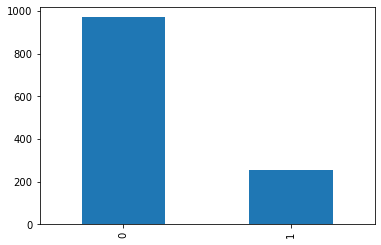

In [1233]:
# critics pick (what we are predicting)
all_data['critics_pick'].value_counts().plot(kind = 'bar')
# looks like most are not critics pick

In [1234]:
set(all_data['Rated'])

{'G',
 'MA-17',
 'Not Rated',
 'PG',
 'PG-13',
 'R',
 'TV-14',
 'TV-G',
 'TV-MA',
 'TV-PG',
 'TV-Y7',
 'Unrated',
 nan}

<AxesSubplot:>

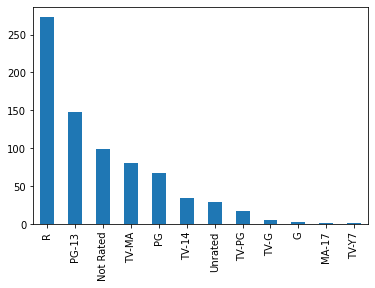

In [1235]:
# rating
all_data['Rated'].value_counts().plot(kind = 'bar')

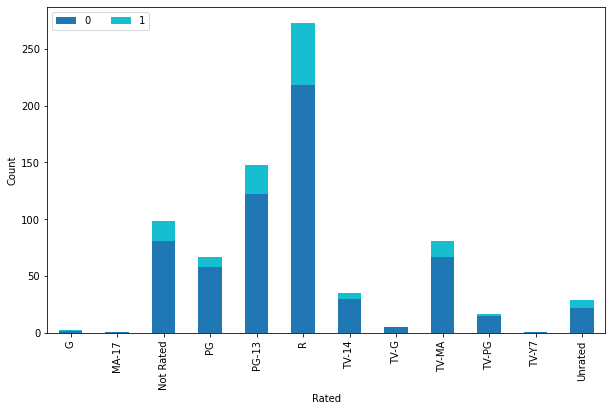

In [1236]:
# now we can look at each by critics choice -- doesn't look like huge chunk of any one genre has critics choice
cross_tab_prop = pd.crosstab(index=all_data['Rated'],
                             columns=all_data['critics_pick'])
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Rated")
plt.ylabel("Count")
plt.show()

In [1237]:
list(set(all_data['Rated']))

[nan,
 'Unrated',
 'TV-PG',
 'MA-17',
 'TV-Y7',
 'PG-13',
 'TV-MA',
 'PG',
 'TV-G',
 'Not Rated',
 'TV-14',
 'G',
 'R']

In [1238]:
# now just turn into numerical values
ratings_dict = {}
for i, name in zip(range(len(list(set(all_data['Rated'])))), list(set(all_data['Rated']))):
    ratings_dict[name] = i
all_data['Rating_num'] = all_data['Rated']
all_data = all_data.replace({"Rating_num": ratings_dict})

In [1239]:
# Genre
all_data['Genre'].value_counts()

Documentary                  233
Drama                        144
Comedy, Drama                 46
Comedy                        28
Drama, Horror, Mystery        27
                            ... 
Action, Comedy, Horror         1
Drama, Family, Fantasy         1
Documentary, Crime, Sport      1
Comedy, Family, Romance        1
Short, Comedy                  1
Name: Genre, Length: 235, dtype: int64

In [1240]:
# let's clean that up a bit
# find the unique genres
all_genres = []
all_data['Genre'] = all_data['Genre'].astype(str)
for genres_string in list(all_data['Genre']):
    genre_list = genres_string.split(',')
    for genre in genre_list:
        all_genres.append(genre.strip())
unique_genres = list(set(all_genres))
unique_genres

['Sport',
 'Western',
 'Horror',
 'Comedy',
 'War',
 'Drama',
 'Crime',
 'Thriller',
 'Fantasy',
 'Documentary',
 'Music',
 'Short',
 'Family',
 'History',
 'Musical',
 'Sci-Fi',
 'Animation',
 'Adventure',
 'Biography',
 'Action',
 'nan',
 'Mystery',
 'Talk-Show',
 'Romance']

In [1241]:
# now create a variable for each genre and assign 1 if listed for genre description
for genre in unique_genres:
    values = []
    for genre_description in all_data['Genre']:
        if genre in genre_description:
            values.append(1)
        else:
            values.append(0)
    all_data[genre] = values

In [1242]:
# moving genre to end of dataframe with assignments
genre = all_data.pop('Genre')
all_data['genre'] = genre

In [1243]:
# now viewing changes made
all_data.iloc[: , -25:]

,Sport,Western,Horror,Comedy,War,Drama,Crime,Thriller,Fantasy,Documentary,...,Sci-Fi,Animation,Adventure,Biography,Action,nan,Mystery,Talk-Show,Romance,genre
0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,"Action, Sci-Fi, Thriller"
1,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,"Action, Adventure, Drama"
2,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,"Action, Adventure, Fantasy"
3,0,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,"Animation, Adventure, Comedy"
4,0,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,"Animation, Adventure, Comedy"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,"Short, Action"
1223,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Short, Drama"
1224,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"Crime, Drama"
1225,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,"Action, Crime, Drama"


In [1244]:
# looks good! we'll remove the nan column as it is not needed
all_data = all_data.drop(columns = ['nan'])

In [1245]:
# now we can look at the distribution of the genres
genres_df = all_data.iloc[: , -24:-1]
genres_df

,Sport,Western,Horror,Comedy,War,Drama,Crime,Thriller,Fantasy,Documentary,...,History,Musical,Sci-Fi,Animation,Adventure,Biography,Action,Mystery,Talk-Show,Romance
0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1223,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1224,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1225,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


<AxesSubplot:>

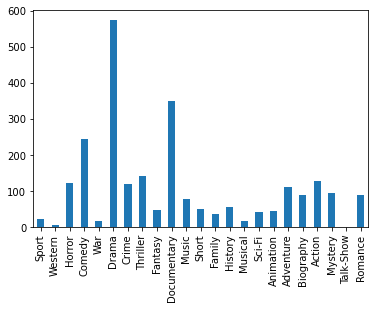

In [1246]:
genres_df.sum().plot(kind = 'bar')

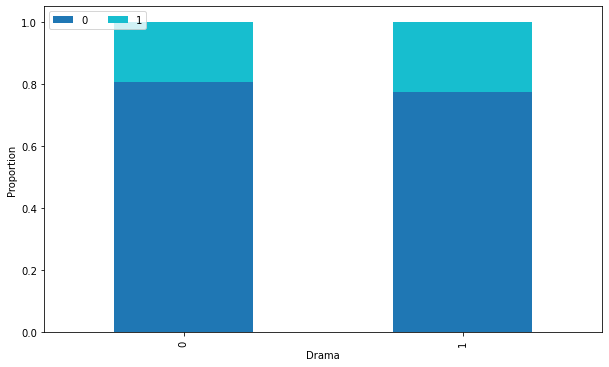

In [1247]:
# looking at a couple of genres where critics pick
cross_tab_prop = pd.crosstab(index=all_data['Drama'],
                             columns=all_data['critics_pick'],
                            normalize = 'index')
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Drama")
plt.ylabel("Proportion")
plt.show()

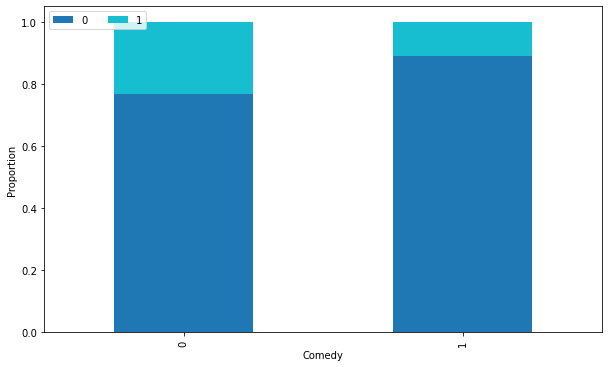

In [1248]:
cross_tab_prop = pd.crosstab(index=all_data['Comedy'],
                             columns=all_data['critics_pick'],
                            normalize = 'index')
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Comedy")
plt.ylabel("Proportion")
plt.show()

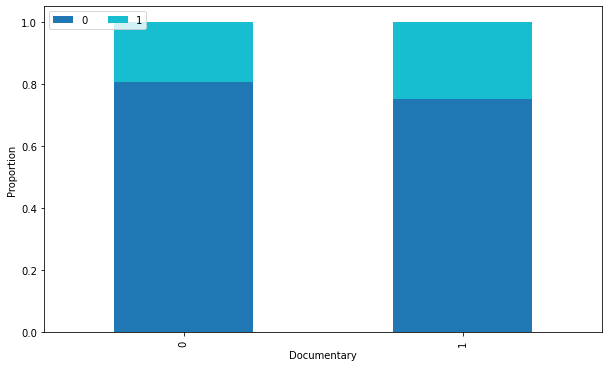

In [1249]:
cross_tab_prop = pd.crosstab(index=all_data['Documentary'],
                             columns=all_data['critics_pick'],
                            normalize = 'index')
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Documentary")
plt.ylabel("Proportion")
plt.show()

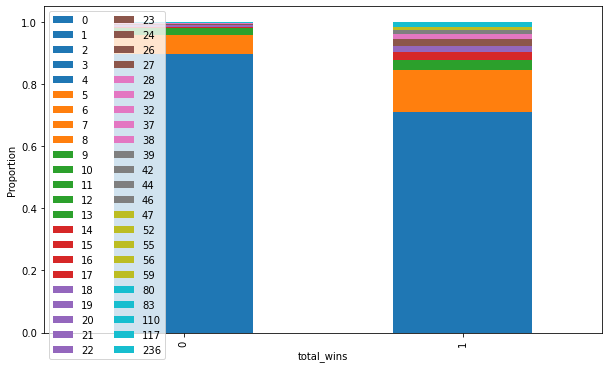

In [1250]:
# now looking at wins
cross_tab_prop = pd.crosstab(index=all_data['critics_pick'],
                             columns=all_data['total_wins'],
                            normalize = 'index')
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("total_wins")
plt.ylabel("Proportion")
plt.show()

# it's a little rough looking with no filtering but we can see that movies not critics pick have less wins than critics picks

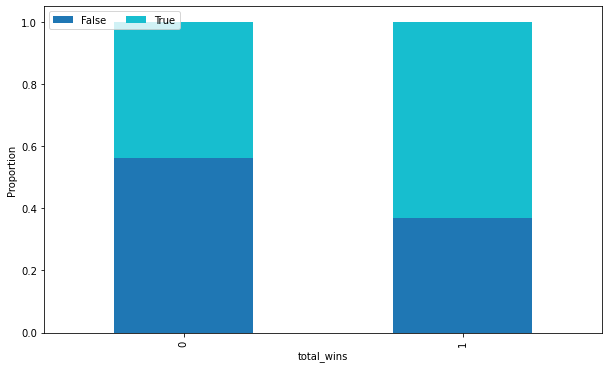

In [1251]:
# let's create a new category for "won_something"
all_data['won_something'] = all_data['total_wins'].apply(lambda x: True if int(x) > 0 else False)

# now plot as above
cross_tab_prop = pd.crosstab(index=all_data['critics_pick'],
                             columns=all_data['won_something'],
                            normalize = 'index')
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("total_wins")
plt.ylabel("Proportion")
plt.show()

<AxesSubplot:ylabel='Frequency'>

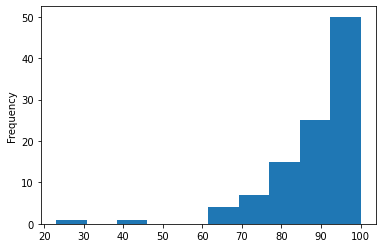

In [1252]:
# distribution of rotten tomatoes by critics choice (the picks)
all_data[all_data['critics_pick'] == 1]['Rotten Tomatoes'].plot(kind = 'hist')

<AxesSubplot:ylabel='Frequency'>

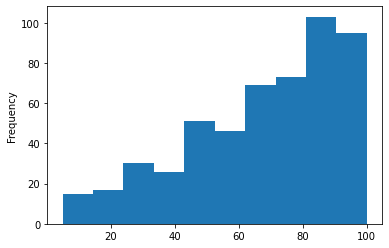

In [1253]:
# distribution of rotten tomatoes by critics choice (not picked)
all_data[all_data['critics_pick'] == 0]['Rotten Tomatoes'].plot(kind = 'hist')

<AxesSubplot:ylabel='Frequency'>

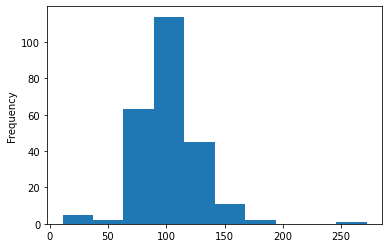

In [1254]:
# now runtime minutes (picked)
all_data[all_data['critics_pick'] == 1]['Runtime_mins'].plot(kind = 'hist')

<AxesSubplot:ylabel='Frequency'>

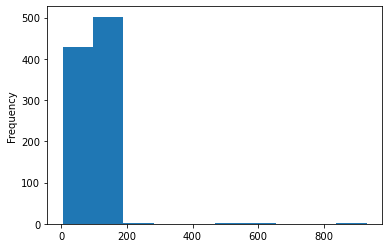

In [1255]:
# now runtime minutes (not picked)
all_data[all_data['critics_pick'] == 0]['Runtime_mins'].plot(kind = 'hist')
# some obvious skew issues here, but not exploring just yet

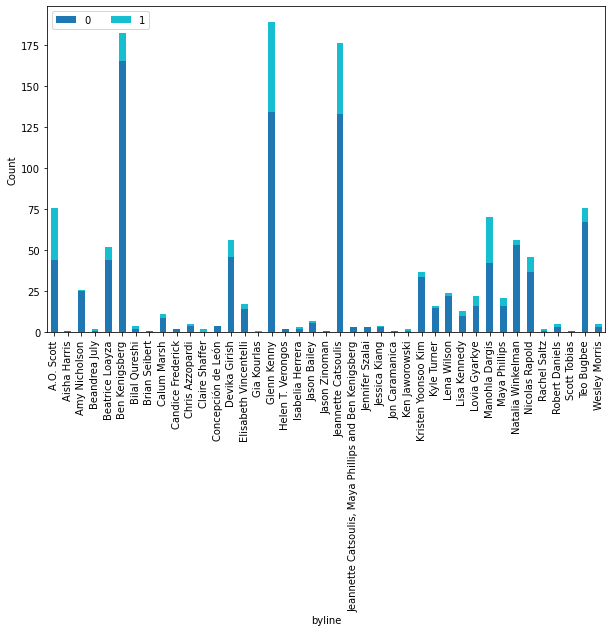

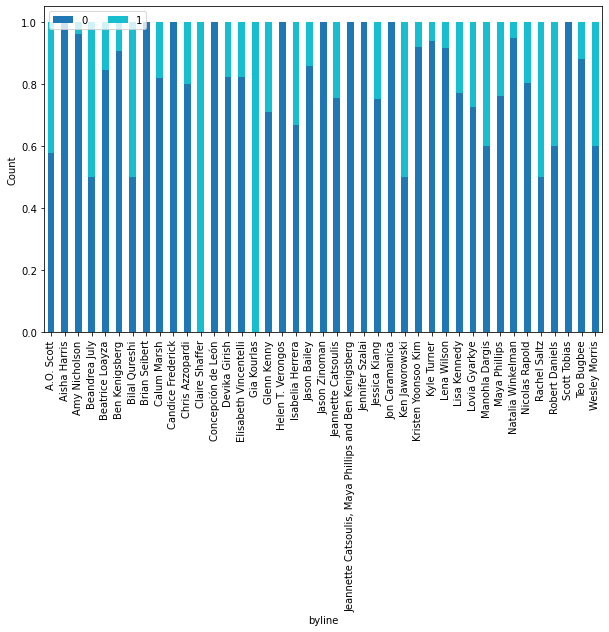

In [1256]:
# now let's check the bylines
cross_tab_prop = pd.crosstab(index=all_data['byline'],
                             columns=all_data['critics_pick'])
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("byline")
plt.ylabel("Count")
plt.show()

cross_tab_prop = pd.crosstab(index=all_data['byline'],
                             columns=all_data['critics_pick'],
                            normalize = 'index')
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("byline")
plt.ylabel("Count")
plt.show()
# looks like there are a few common reviewers and some that have only given critics picks while other never, or rarely, do

In [1257]:
# now we need to convert the reviewers to integers for the model (like we did with rating)
ratings_dict = {}
for i, name in zip(range(len(list(set(all_data['byline'])))), list(set(all_data['byline']))):
    ratings_dict[name] = i
all_data['byline_num'] = all_data['byline']
all_data = all_data.replace({"byline_num": ratings_dict})

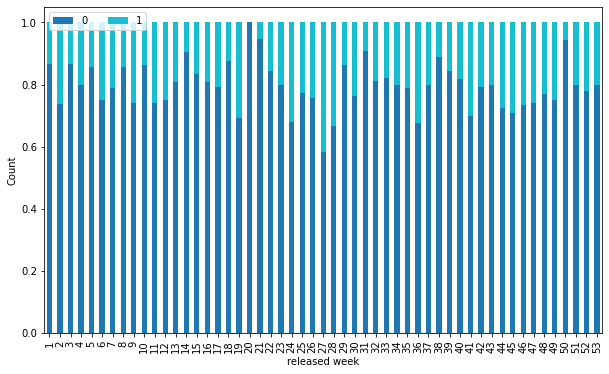

In [1258]:
# we're also going to consider release date
# we'll do it by week of the year
all_data['Released'] = pd.to_datetime(all_data['Released'])
weeks = []
for x in all_data['Released']:
    if str(x) != 'NaT':
        week = x.isocalendar()[1]
    else:
        week = x
    weeks.append(week)
all_data['Released_week'] = weeks

# now let's look at the proportions
cross_tab_prop = pd.crosstab(index=all_data['Released_week'],
                             columns=all_data['critics_pick'],
                            normalize = 'index')
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("released week")
plt.ylabel("Count")
plt.show()

# kind of looks like summer weeks have more picks proportionally

<AxesSubplot:ylabel='Frequency'>

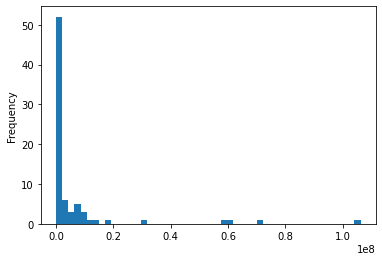

In [1259]:
# let's look at box office now
all_data[all_data['critics_pick'] == 1]['BoxOffice'].plot(kind = 'hist', bins = 50)

<AxesSubplot:ylabel='Frequency'>

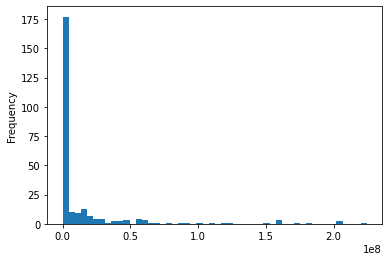

In [1260]:
# let's look at box office now
all_data[all_data['critics_pick'] == 0]['BoxOffice'].plot(kind = 'hist', bins = 50)
# just looks like slightly more spread in non picks

In [1261]:
# despite just looking at some of the variables, we will include most in the modeling section and use feature selection

In [1262]:
# need to fix where NaT type -- should be NoneType
all_data = all_data.astype(object).where(all_data.notnull(), None)
# filling in null values to get model to work
all_data = pd.DataFrame(all_data).fillna(-9)

# Modeling: without text features

In [1263]:
random.seed(2)

In [1264]:
# split into train and test (train on 2020, test on 2021)
train = all_data[all_data['Year'] == '2020']
test = all_data[all_data['Year'] == '2021']

# view counts for each
print('train count: ', len(train))
print('test count: ', len(test))

train count:  484
test count:  436


Experiment with variables we think are a good fit: RandomForestClassifier

In [1265]:
X_train = train[['Rating_num', 'Action','Drama','Horror','Family','Short','Sport','Sci-Fi','Documentary',
 'Thriller','Adventure','Released_week', 'Runtime_mins','BoxOffice', 'Rotten Tomatoes', 
 'oscar_wins', 'oscar_noms','total_wins', 'total_noms','byline_num']]
y_train = train['critics_pick']
X_test = test[['Rating_num', 'Action','Drama','Horror','Family','Short','Sport','Sci-Fi','Documentary',
 'Thriller','Adventure','Released_week', 'Runtime_mins','BoxOffice', 'Rotten Tomatoes', 
 'oscar_wins', 'oscar_noms','total_wins', 'total_noms','byline_num']]
y_test = test['critics_pick']

In [1266]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42, max_features = 1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
report = classification_report(y_test, y_pred)
print('report:', report, sep='\n')

report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       355
           1       0.35      0.07      0.12        81

    accuracy                           0.80       436
   macro avg       0.59      0.52      0.51       436
weighted avg       0.73      0.80      0.75       436



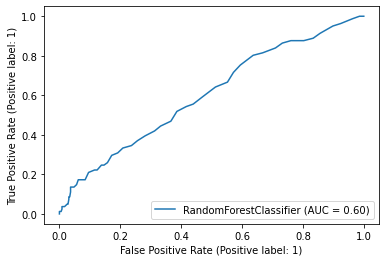

In [1267]:
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test)
plt.show()

Next let's do it with feature selection: Random Forest Classifier

In [1268]:
X_train = train[['Rating_num', 'Action','Mystery','Fantasy','Animation','Romance','Drama','History','Western',
 'Crime','Comedy','Horror','Family','Short','Sport','Sci-Fi','Documentary','Music','Biography','Talk-Show',
 'Thriller','War','Adventure','Musical', 'Released_week', 'Runtime_mins','imdbRating', 'imdbVotes','BoxOffice', 
 'Rotten Tomatoes', 'Metacritic', 'oscar_wins', 'oscar_noms','emmy_wins', 'emmy_noms', 'total_wins', 'total_noms','byline_num']]
y_train = train['critics_pick']

In [1269]:
rfc = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state = 42, max_features = 1))
rfc.fit(X_train, y_train)
rfc.get_support()
selected_feat= X_train.columns[(rfc.get_support())]
len(selected_feat)
print(selected_feat)

Index(['Rating_num', 'Released_week', 'Runtime_mins', 'imdbRating',
       'imdbVotes', 'BoxOffice', 'Rotten Tomatoes', 'Metacritic', 'total_wins',
       'total_noms', 'byline_num'],
      dtype='object')


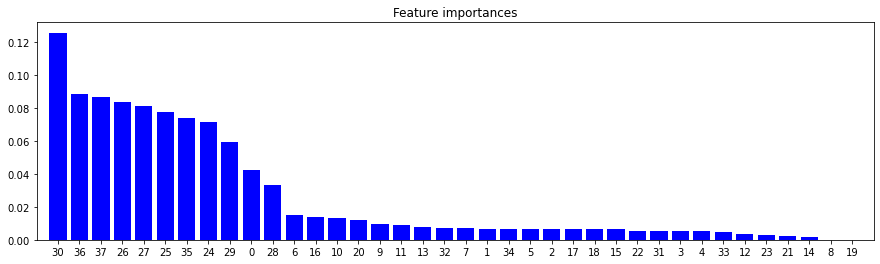

In [1270]:
importances = rfc.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
# X is the train data used to fit the model 
plt.figure(figsize=(15, 4))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [1271]:
# first most important feature
X_train.columns[30]

'Metacritic'

In [1272]:
# second-ninth most important feature in order
for i in [36, 35, 25, 27, 37, 26, 24, 29]:
    print(X_train.columns[i])

total_noms
total_wins
Runtime_mins
imdbVotes
byline_num
imdbRating
Released_week
Rotten Tomatoes


In [1273]:
X_train = train[['Rating_num', 'Released_week', 'Runtime_mins', 'imdbRating',
       'imdbVotes', 'Rotten Tomatoes', 'Metacritic', 'total_wins',
       'total_noms', 'byline_num']]
X_test = test[['Rating_num', 'Released_week', 'Runtime_mins', 'imdbRating',
       'imdbVotes', 'Rotten Tomatoes', 'Metacritic', 'total_wins',
       'total_noms', 'byline_num']]
y_test = test['critics_pick']
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42, max_features = 1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
report = classification_report(y_test, y_pred)
print('report:', report, sep='\n')

report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       355
           1       0.61      0.17      0.27        81

    accuracy                           0.83       436
   macro avg       0.72      0.57      0.59       436
weighted avg       0.80      0.83      0.78       436



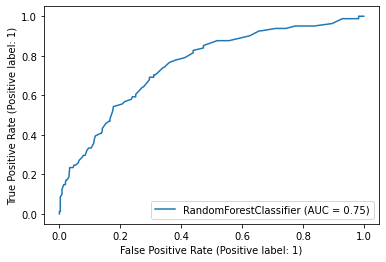

In [1274]:
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test)
plt.show()

Experiment with variables we think are a good fit: LogisticRegression

In [1275]:
X_train = train[['Rating_num', 'Action','Drama','Horror','Family','Short','Sport','Sci-Fi','Documentary',
 'Thriller','Adventure','Released_week', 'Runtime_mins','BoxOffice', 'Rotten Tomatoes', 
 'oscar_wins', 'oscar_noms','total_wins', 'total_noms','byline_num']]
y_train = train['critics_pick']
X_test = test[['Rating_num', 'Action','Drama','Horror','Family','Short','Sport','Sci-Fi','Documentary',
 'Thriller','Adventure','Released_week', 'Runtime_mins','BoxOffice', 'Rotten Tomatoes', 
 'oscar_wins', 'oscar_noms','total_wins', 'total_noms','byline_num']]
y_test = test['critics_pick']

In [1276]:
lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
report = classification_report(y_test, y_pred)
print('report:', report, sep='\n')

report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       355
           1       0.35      0.10      0.15        81

    accuracy                           0.80       436
   macro avg       0.59      0.53      0.52       436
weighted avg       0.73      0.80      0.75       436



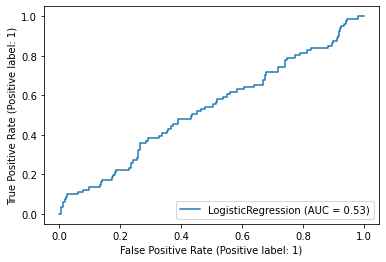

In [1277]:
lr_disp = RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.show()

Next let's do it with feature selection: Logistic Regression

In [1278]:
X_train = train[['Rating_num', 'Action','Mystery','Fantasy','Animation','Romance','Drama','History','Western',
 'Crime','Comedy','Horror','Family','Short','Sport','Sci-Fi','Documentary','Music','Biography','Talk-Show',
 'Thriller','War','Adventure','Musical', 'Released_week', 'Runtime_mins','imdbRating', 'imdbVotes','BoxOffice', 
 'Rotten Tomatoes', 'Metacritic', 'oscar_wins', 'oscar_noms','emmy_wins', 'emmy_noms', 'total_wins', 'total_noms','byline_num']]
y_train = train['critics_pick']

In [1279]:
lr = SelectFromModel(LogisticRegression(random_state = 42))
lr.fit(X_train, y_train)
lr.get_support()
selected_feat= X_train.columns[(lr.get_support())]
len(selected_feat)
print(selected_feat)

Index(['Released_week', 'Runtime_mins', 'Rotten Tomatoes', 'Metacritic',
       'byline_num'],
      dtype='object')


In [1280]:
X_train = train[['Released_week', 'Runtime_mins', 'Rotten Tomatoes', 'Metacritic',
       'byline_num']]
X_test = test[['Released_week', 'Runtime_mins', 'Rotten Tomatoes', 'Metacritic',
       'byline_num']]
y_test = test['critics_pick']
lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
report = classification_report(y_test, y_pred)
print('report:', report, sep='\n')

report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       355
           1       1.00      0.06      0.12        81

    accuracy                           0.83       436
   macro avg       0.91      0.53      0.51       436
weighted avg       0.86      0.83      0.76       436



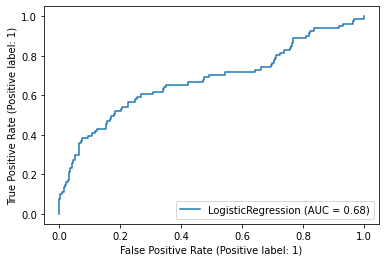

In [1281]:
lr_disp = RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.show()

# Modeling with text features

Merge text data

In [1282]:
text_related_df = pd.read_csv('NYT_Reviews_w_TopicRelatedness_02.csv')
text_related_df = text_related_df[['display_title', 'Topic   #1', 'Topic   #2',
       'Topic   #3', 'Topic   #4', 'Topic   #5', 'Topic   #6', 'Topic   #7',
       'Topic   #8', 'Topic   #9', 'Topic   #10' ]]
data_with_relatedness = all_data.merge(text_related_df, on = 'display_title', how = 'inner')
# filling in null values to get model to work
data_with_relatedness = pd.DataFrame(data_with_relatedness).fillna(-9)

In [1283]:
# split into train and test (train on 2020, test on 2021)
train = data_with_relatedness[data_with_relatedness['Year'] == '2020']
test = data_with_relatedness[data_with_relatedness['Year'] == '2021']

Model Random Forest with Feature Selection including topic relatedness

In [1284]:
X_train = train[['Rating_num', 'Action','Mystery','Fantasy','Animation','Romance','Drama','History','Western',
 'Crime','Comedy','Horror','Family','Short','Sport','Sci-Fi','Documentary','Music','Biography','Talk-Show',
 'Thriller','War','Adventure','Musical', 'Released_week', 'Runtime_mins','imdbRating', 'imdbVotes','BoxOffice', 
 'Rotten Tomatoes', 'Metacritic', 'oscar_wins', 'oscar_noms','emmy_wins', 'emmy_noms', 'total_wins', 'total_noms','byline_num',
                'Topic   #1', 'Topic   #2',
       'Topic   #3', 'Topic   #4', 'Topic   #5', 'Topic   #6', 'Topic   #7',
       'Topic   #8', 'Topic   #9', 'Topic   #10']]
y_train = train['critics_pick']

In [1285]:
rfc = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state = 42, max_features = 1))
rfc.fit(X_train, y_train)
rfc.get_support()
selected_feat= X_train.columns[(rfc.get_support())]
len(selected_feat)
print(selected_feat)
# look like all topics are important features!

Index(['Rating_num', 'Released_week', 'Runtime_mins', 'imdbRating',
       'imdbVotes', 'Rotten Tomatoes', 'Metacritic', 'total_wins',
       'total_noms', 'byline_num', 'Topic   #1', 'Topic   #2', 'Topic   #3',
       'Topic   #4', 'Topic   #5', 'Topic   #6', 'Topic   #7', 'Topic   #8',
       'Topic   #9', 'Topic   #10'],
      dtype='object')


In [1286]:
X_train = train[['Rating_num', 'Released_week', 'Runtime_mins', 'imdbRating',
       'imdbVotes', 'Rotten Tomatoes', 'Metacritic', 'total_wins',
       'total_noms', 'byline_num', 'Topic   #1', 'Topic   #2', 'Topic   #3',
       'Topic   #4', 'Topic   #5', 'Topic   #6', 'Topic   #7', 'Topic   #8',
       'Topic   #9', 'Topic   #10']]
X_test = test[['Rating_num', 'Released_week', 'Runtime_mins', 'imdbRating',
       'imdbVotes', 'Rotten Tomatoes', 'Metacritic', 'total_wins',
       'total_noms', 'byline_num', 'Topic   #1', 'Topic   #2', 'Topic   #3',
       'Topic   #4', 'Topic   #5', 'Topic   #6', 'Topic   #7', 'Topic   #8',
       'Topic   #9', 'Topic   #10']]
y_test = test['critics_pick']
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42, max_features = 1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
report = classification_report(y_test, y_pred)
print('report:', report, sep='\n')

report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       355
           1       0.55      0.26      0.35        81

    accuracy                           0.82       436
   macro avg       0.70      0.61      0.63       436
weighted avg       0.79      0.82      0.80       436



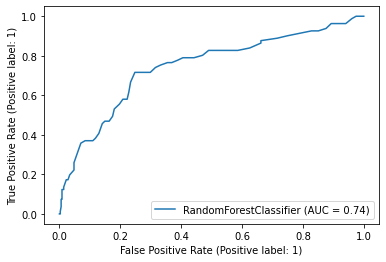

In [1287]:
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test)
plt.show()

Model Random Forest with Feature Selection including topic assignment

In [1288]:
text_assign_df = pd.read_csv('NYT_Reviews_w_TopicAssignment_02.csv')
text_assign_df = text_assign_df[['display_title', 'Topic_Assignment']]
data_with_topic_assignment = all_data.merge(text_assign_df, on = 'display_title', how = 'inner')
# filling in null values to get model to work
data_with_topic_assignment = pd.DataFrame(data_with_topic_assignment).fillna(-9)
# change to numeric
topic_dict = {}
for i, name in zip(range(len(list(set(data_with_topic_assignment['Topic_Assignment'])))), 
                   list(set(data_with_topic_assignment['Topic_Assignment']))):
    topic_dict[name] = i
data_with_topic_assignment['Topic_Assignment_num'] = data_with_topic_assignment['Topic_Assignment']
data_with_topic_assignment = data_with_topic_assignment.replace({"Topic_Assignment_num": topic_dict})

In [1289]:
# split into train and test (train on 2020, test on 2021)
train = data_with_topic_assignment[data_with_topic_assignment['Year'] == '2020']
test = data_with_topic_assignment[data_with_topic_assignment['Year'] == '2021']

In [1290]:
X_train = train[['Rating_num', 'Action','Mystery','Fantasy','Animation','Romance','Drama','History','Western',
 'Crime','Comedy','Horror','Family','Short','Sport','Sci-Fi','Documentary','Music','Biography','Talk-Show',
 'Thriller','War','Adventure','Musical', 'Released_week', 'Runtime_mins','imdbRating', 'imdbVotes','BoxOffice', 
 'Rotten Tomatoes', 'Metacritic', 'oscar_wins', 'oscar_noms','emmy_wins', 'emmy_noms', 'total_wins', 'total_noms','byline_num',
                'Topic_Assignment_num']]
y_train = train['critics_pick']

In [1291]:
rfc = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state = 42, max_features = 1))
rfc.fit(X_train, y_train)
rfc.get_support()
selected_feat= X_train.columns[(rfc.get_support())]
len(selected_feat)
print(selected_feat)
# look like the topic is an important feature!

Index(['Rating_num', 'Released_week', 'Runtime_mins', 'imdbRating',
       'imdbVotes', 'BoxOffice', 'Rotten Tomatoes', 'Metacritic', 'total_wins',
       'total_noms', 'byline_num', 'Topic_Assignment_num'],
      dtype='object')


In [1292]:
X_train = train[['Rating_num', 'Released_week', 'Runtime_mins', 'imdbRating',
       'imdbVotes', 'BoxOffice', 'Rotten Tomatoes', 'Metacritic', 'total_wins',
       'total_noms', 'byline_num', 'Topic_Assignment_num']]
X_test = test[['Rating_num', 'Released_week', 'Runtime_mins', 'imdbRating',
       'imdbVotes', 'BoxOffice', 'Rotten Tomatoes', 'Metacritic', 'total_wins',
       'total_noms', 'byline_num', 'Topic_Assignment_num']]
y_test = test['critics_pick']
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42, max_features = 1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
report = classification_report(y_test, y_pred)
print('report:', report, sep='\n')

report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       355
           1       0.64      0.20      0.30        81

    accuracy                           0.83       436
   macro avg       0.74      0.59      0.60       436
weighted avg       0.80      0.83      0.79       436



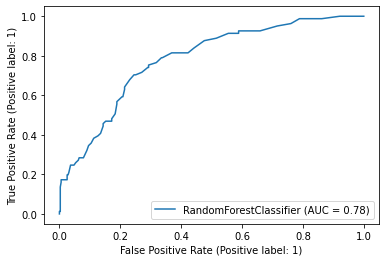

In [1293]:
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test)
plt.show()